In [37]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL

  Using cached https://files.pythonhosted.org/packages/89/99/0e3522a9764fe371bf9f7729404b1ef7d9c4fc49cbe5f1761c6e07812345/Pillow-4.0.0-cp27-cp27mu-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [38]:
# we will download the cats and dogs dataset and unzip them
# after this run, set your data_dir variable: data_dir = 'Cat_Dog_data'
# so all the data is available. so path to your training data becomes `Cat_Dog_data/train`
# path to test is `Cat_Dog_data/test`

!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

# remove existing directories
!rm -r Cat_Dog_data __MACOSX || true
!unzip -qq Cat_Dog_data.zip

--2018-11-28 08:15:20--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.69|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [39]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
   print "CUDA is not available.  Training on CPU ..."
else:
   print "CUDA is available!  Training on GPU ..."

CUDA is available!  Training on GPU ...


In [0]:
train_transforms =transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms =transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('Cat_Dog_data/train/', transform=train_transforms)
test_data = datasets.ImageFolder('Cat_Dog_data/test/', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [41]:
model=models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
# freeze our feature parameters
for param in model.parameters():
    param.requires_grad=False

from collections import OrderedDict
classifier=nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(1024,256)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(256,64)),
    ('relu',nn.ReLU()),
    ('fc3',nn.Linear(64,2)),
    ('output',nn.LogSoftmax(dim=1))
]))

model.classifier=classifier

In [43]:
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.classifier.parameters(),lr=0.001)
device=torch.device("cuda")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [44]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5

train_losses,test_losses=[],[]
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            print("Epoch {}/{}.. "
                  "Step {} "
                  "Train loss: {:.3f}.. "
                  "Test loss: {:.3f}.. "
                  "Test accuracy: {:.3f}".format
                  (epoch+1,epochs,steps,running_loss/print_every,test_loss/len(testloader),accuracy/len(testloader)))
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))
            running_loss = 0
            model.train()
            

Epoch 1/1.. Step 5 Train loss: 0.575.. Test loss: 0.306.. Test accuracy: 0.958
Epoch 1/1.. Step 10 Train loss: 0.309.. Test loss: 0.129.. Test accuracy: 0.958
Epoch 1/1.. Step 15 Train loss: 0.229.. Test loss: 0.333.. Test accuracy: 0.853
Epoch 1/1.. Step 20 Train loss: 0.208.. Test loss: 0.099.. Test accuracy: 0.958
Epoch 1/1.. Step 25 Train loss: 0.156.. Test loss: 0.105.. Test accuracy: 0.956
Epoch 1/1.. Step 30 Train loss: 0.208.. Test loss: 0.167.. Test accuracy: 0.934
Epoch 1/1.. Step 35 Train loss: 0.179.. Test loss: 0.096.. Test accuracy: 0.959
Epoch 1/1.. Step 40 Train loss: 0.176.. Test loss: 0.104.. Test accuracy: 0.956
Epoch 1/1.. Step 45 Train loss: 0.136.. Test loss: 0.113.. Test accuracy: 0.952
Epoch 1/1.. Step 50 Train loss: 0.139.. Test loss: 0.088.. Test accuracy: 0.962
Epoch 1/1.. Step 55 Train loss: 0.153.. Test loss: 0.088.. Test accuracy: 0.964
Epoch 1/1.. Step 60 Train loss: 0.178.. Test loss: 0.326.. Test accuracy: 0.866
Epoch 1/1.. Step 65 Train loss: 0.239.. T

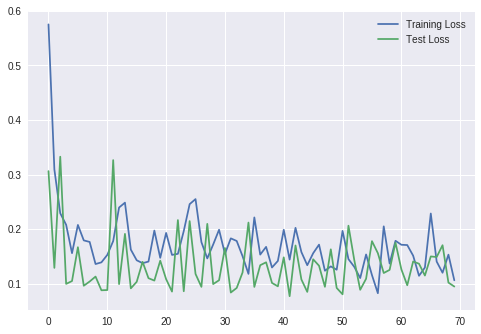

In [45]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend(frameon=False)